# Introduction

In the nsrdb_srrl_exploratory_analysis notebook, we saw that NSRDB is more generous at classifying clear sky times.  This was an expected outcome as clear skies are designated 30min at a time.  What we also saw, was cases where SRRL measurements were labeled as cloudy, but looked clear due (from a glance).  In this notebook, we will try to see which tests are failed and why.

# Imports, configs, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

# Load SRRL and NSRDB data

SRRL data is available at https://www.nrel.gov/midc/srrl_bms/ and NSRDB data is available at http://bit.ly/2oFzFMI.  NSRDB is not as up to date as SRRL, so we will just use 2014 (and sub-samples thereof) for analysis.

In [2]:
srrl_file = os.path.expanduser('~/data_sets/srrl/20140101.csv')
nsrdb_file = os.path.expanduser('~/data_sets/nsrdb/SRRL_BMS_2010_global.csv')

In [3]:
srrl_data = pd.read_csv(srrl_file)

In [4]:
srrl_data.index = pd.to_datetime(srrl_data['DATE (MM/DD/YYYY)'] + ' ' + srrl_data['MST'])

In [5]:
srrl_data.index = srrl_data.index.tz_localize('Etc/GMT+7')

In [6]:
srrl_data = srrl_data[~srrl_data.index.duplicated(keep='first')]

In [7]:
srrl_data = srrl_data.reindex(
    pd.date_range(start=srrl_data.index[0], end=srrl_data.index[-1], freq='1min')
).fillna(0)

In [8]:
srrl_data.drop(['DATE (MM/DD/YYYY)', 'MST'], inplace=True, axis=1)

In [9]:
nsrdb_cols = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'DHI', 'DNI', 'GHI', 'Cloud Type']

In [10]:
nsrdb_data = pd.read_csv(nsrdb_file, header=2, usecols=nsrdb_cols)

In [11]:
nsrdb_data[['Year', 'Month', 'Day', 'Hour', 'Minute']] = \
    nsrdb_data[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str)

In [12]:
nsrdb_data.index = pd.to_datetime(nsrdb_data['Year'] + '/' + 
                                  nsrdb_data['Month'] + '/' +
                                  nsrdb_data['Day'] + ' ' +
                                  nsrdb_data['Hour'] + ':' + 
                                  nsrdb_data['Minute'])

In [13]:
nsrdb_data.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True, axis=1)

In [14]:
nsrdb_data.index = nsrdb_data.index.tz_localize('Etc/GMT+7')

In [15]:
nsrdb_data = nsrdb_data.reindex(
    pd.date_range(start=nsrdb_data.index[0], end=nsrdb_data.index[-1], freq='1min')
).fillna(method='ffill')

In [16]:
data = nsrdb_data.join(srrl_data)

In [17]:
data.head()

DHI  DNI  GHI  Cloud Type  \
2014-01-01 00:00:00-07:00  0.0  0.0  0.0         6.0   
2014-01-01 00:01:00-07:00  0.0  0.0  0.0         6.0   
2014-01-01 00:02:00-07:00  0.0  0.0  0.0         6.0   
2014-01-01 00:03:00-07:00  0.0  0.0  0.0         6.0   
2014-01-01 00:04:00-07:00  0.0  0.0  0.0         6.0   

                           Global 40-South PSP [W/m^2]  \
2014-01-01 00:00:00-07:00                          NaN   
2014-01-01 00:01:00-07:00                          NaN   
2014-01-01 00:02:00-07:00                          NaN   
2014-01-01 00:03:00-07:00                          NaN   
2014-01-01 00:04:00-07:00                          NaN   

                           Global 40-South LI-200 [W/m^2]  
2014-01-01 00:00:00-07:00                             NaN  
2014-01-01 00:01:00-07:00                             NaN  
2014-01-01 00:02:00-07:00                             NaN  
2014-01-01 00:03:00-07:00                             NaN  
2014-01-01 00:04:00-07:00                             NaN

# Set up PV_Lib clear sky detection

In [18]:
lat = 39.742
lon = -105.18
tilt = 40
azimuth = 180
elevation = 1828.8

system_noloc = pvlib.pvsystem.PVSystem(surface_tilt=tilt, surface_azimuth=azimuth)
loc = pvlib.location.Location(lat, lon, altitude=elevation)
system_loc = pvlib.pvsystem.LocalizedPVSystem(pvsystem=system_noloc, location=loc)

# Analysis function

We want to quanitify how well PVLib and NSRDB agree on cloudy/clear periods.  This agreement is defined as

## $A = \frac{1}{N_{\mathrm{CS}}} \sum_{i}^{N_{\text{CS}}} b_i c_i$

where $b_i$ represents PVLib clear sky (1 if clear, 0 if not) and $c_i$ represents NSRDB clear minutes (1 if clear, 0 if not).  $N_\text{CS}$ are the number of clear sky days (from either PVLIB or NSRDB classification).

In [19]:
def agreement_analysis(sample, clear_skies, window=10, 
                       start_end=None, return_components=False, viz=True, sample_key='Global 40-South LI-200 [W/m^2]'):
    # detect clear skies
    if return_components:
        is_clear, components, alpha = pvlib.clearsky.detect_clearsky(sample[sample_key], 
                                                                     clear_skies['ghi'], sample.index, window, 
                                                                     return_components=True)
        components = pd.DataFrame(components)
        while len(components) < len(sample):
            components.loc[len(components)] = [False] * 7
        components.index = sample.index
        # components.index = components.reindex(
        #     pd.date_range(start=sample.index[0], end=sample.index[-1], freq=sample.index.freq)
        # ).fillna(False)
    else:
        is_clear = pvlib.clearsky.detect_clearsky(sample[sample_key], 
                                                  clear_skies['ghi'], sample.index, window)
        alpha = 1
    
    if start_end is not None:
        sample = sample.between_time(start_end[0], start_end[1])
        clear_skies = sample.between_time(start_end[0], start_end[1])
        is_clear = is_clear.between_time(start_end[0], start_end[1])

    # make mask dataframe
    mask = pd.DataFrame()
    mask['pvlib'] = is_clear
    mask['nsrdb'] = (sample['Cloud Type'] == 0)
    mask['consensus'] = mask['pvlib'] & mask['nsrdb']
    
    # calculate maximum and actual agreement between pvlib, nsrdb
    agree_val = mask['consensus'].sum() / len(mask[(mask['pvlib']) | (mask['nsrdb'])]) * 100
    min_val = min(mask['pvlib'].sum(), mask['nsrdb'].sum())
    max_agree_val = min_val / len(mask[(mask['pvlib']) | (mask['nsrdb'])]) * 100                               
    
    # plot findings
    if viz:
        fig, ax = plt.subplots()
        
        _ = ax.plot(clear_skies['ghi'].index, alpha * clear_skies['ghi'], label='scaled model', c='black')

        _ = ax.plot(sample[sample_key].index, 
                sample[sample_key], label='GHI')

        _ = ax.scatter(sample[sample_key][(mask['pvlib']) & (~mask['nsrdb'])].index,
                   sample[sample_key][(mask['pvlib']) & (~mask['nsrdb'])], 
                   marker='o', c='green', label='PVLib')

        _ = ax.scatter(sample[sample_key][(mask['nsrdb']) & (~mask['pvlib'])].index,
                   sample[sample_key][(mask['nsrdb']) & (~mask['pvlib'])],
                   marker='o', label='NSRDB', c='orange')

        _ = ax.scatter(sample[sample_key][mask['consensus']].index,
                   sample[sample_key][mask['consensus']], 
                   marker='o', label='Consensus', c='red')

        _ = ax.set_ylabel('GHI W/m2')
        _ = ax.set_xlabel('Date and time')
        _ = ax.legend()

    if return_components:
        return {'mask': mask,
                'components': components,
                'alpha': alpha,
                'max_agreement': max_agree_val,
                'agreement': agree_val}
    else:
        return {'mask': mask,
                'max_agreement': max_agree_val,
                'agreement': agree_val}

# Investigate potential detection errors

### Sample: First week of July

This is the same analysis as above,  except we restrict the time of day for detection (between 4:30AM and 10:00PM).  This is a very generous time frame, but we don't want to eleminate data that might be of interest.

In [20]:
start_date = '2014-01-03'
end_date = '2014-01-07'
sample = data[(data.index >= start_date) & (data.index < end_date)].copy()

In [21]:
data[data['Global 40-South LI-200 [W/m^2]'] < 0] = 0

In [22]:
clear_skies = system_loc.get_clearsky(sample.index)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff


<IPython.core.display.Javascript object>


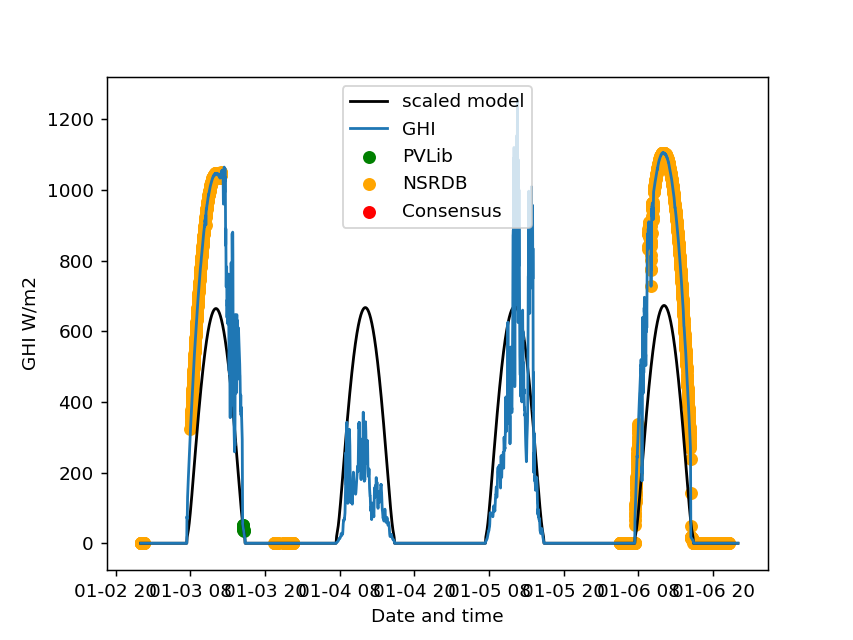

In [23]:
result = agreement_analysis(sample, clear_skies, return_components=True)

Periods that are 'suspiciously' undetected (times are approximate): 
* 7/1: afternoon (1330-1400, 1630-1700)
* 7/2: morning (0900-1000), afternoon (1500-1600)
* 7/3: morning (0700-0830)
* 7/4: morning (0600-0730)
* 7/5: n/a
* 7/6: morning (0700-0800)
* 7/7: morning (0630-0830)

The mornings of 7/3, 7/4, and 7/6 will be investigated first.  They seem to be the most obvious cases of error with the PVLib detection.

In [24]:
def concat_components(pvlib_classified, components, start_date, end_date):
    pvlib_classified = pvlib_classified[(pvlib_classified.index >= start_date) & 
                                        (pvlib_classified.index < end_date)]
    components = components[(components.index >= start_date) & 
                            (components.index < end_date)]
    final = components.join(pvlib_classified)
    return final
    

### July 3rd

In [25]:
start_date = '2014-07-03 07:30:00'
end_date = '2014-07-03 08:16:00'

In [26]:
components = result['components']

In [27]:
mask = result['mask']

In [28]:
detailed_info = concat_components(mask, components, start_date, end_date)

In [29]:
detailed_info

Empty DataFrame
Columns: [mean_diff, max_diff, line_length, slope_nstd, slope_max, mean_nan, windows, pvlib, nsrdb, consensus]
Index: []

It appears that with this detector/set up/parameters, the PVLib struggles to match early mornings correctly.  It fails based on mean_diff and max_diff, sometimes line length.  This is true until 8:06, where we see that 

This issue highlights the largest issue with PVLib: how does one hand tuning parameters without knowing if classification is being done correctly?

We will check the other dates of interest to verify the hypothesis that mean_diff and max_diff are the main culprits for why early mornings are not labeled as clear despite looking so.

### July 4th

In [30]:
start_date = '2014-07-04 06:00:00'
end_date = '2014-07-04 06:46:00'

In [31]:
components = result['components']

In [32]:
mask = result['mask']

In [33]:
detailed_info = concat_components(mask, components, start_date, end_date)

In [34]:
detailed_info

Empty DataFrame
Columns: [mean_diff, max_diff, line_length, slope_nstd, slope_max, mean_nan, windows, pvlib, nsrdb, consensus]
Index: []

Once again, it appears that mean_diff and max_diff are the main reasons why these periods are not listed as clear.  Line length is also an issue early on, but we see that before 6:09/6:10, the measured curve has a very soft slope.  It increases to be much more consistent with the model curve soon after this time, which makes it less of a concern, though it still appears that it should have been labeled clear.

### July 6th

In [35]:
start_date = '2014-07-06 07:30:00'
end_date = '2014-07-06 08:16:00'

In [36]:
components = result['components']

In [37]:
mask = result['mask']

In [38]:
detailed_info = concat_components(mask, components, start_date, end_date)

In [39]:
detailed_info

Empty DataFrame
Columns: [mean_diff, max_diff, line_length, slope_nstd, slope_max, mean_nan, windows, pvlib, nsrdb, consensus]
Index: []

This third sample once again shows that mean_diff and max_diff are the reasons why seemingly clear sky is labeled as cloudy.  Changing the tolerane to be more lenient will likely fix this issue, but it will also affect the entire detection system since scaling to the model is applied globally.

# Outlook

It's obvious that the default tolerances for mean_diff and max_diff are unsuitable for this data set.  While many clear sky periods are detected, it is alarming that the method fails for seemingly obvious cases as well.  

In [40]:
def ben_detect_clearsky(measured, clearsky, times, window_length,
                    mean_diff=75, max_diff=75,
                    lower_line_length=-5, upper_line_length=10,
                    var_diff=0.005, slope_dev=8, max_iterations=20,
                    return_components=False):
    # calculate deltas in units of minutes (matches input window_length units)
    deltas = np.diff(times) / np.timedelta64(1, '60s')

    # determine the unique deltas and if we can proceed
    unique_deltas = np.unique(deltas)
    if len(unique_deltas) == 1:
        sample_interval = unique_deltas[0]
    else:
        raise NotImplementedError('algorithm does not yet support unequal ' \
                                  'times. consider resampling your data.')

    samples_per_window = int(window_length / sample_interval)

    # generate matrix of integers for creating windows with indexing
    from scipy.linalg import hankel
    H = hankel(np.arange(samples_per_window),
               np.arange(samples_per_window-1, len(times)))

    # calculate measurement statistics
    meas_mean = np.mean(measured[H], axis=0)
    meas_max = np.max(measured[H], axis=0)
    meas_slope = np.diff(measured[H], n=1, axis=0)
    # matlab std function normalizes by N-1, so set ddof=1 here
    meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
    meas_slope_max = np.max(np.abs(meas_slope), axis=0)
    meas_line_length = np.sum(np.sqrt(
        meas_slope*meas_slope + sample_interval*sample_interval), axis=0)

    # calculate clear sky statistics
    clear_mean = np.mean(clearsky[H], axis=0)
    clear_max = np.max(clearsky[H], axis=0)
    clear_slope = np.diff(clearsky[H], n=1, axis=0)
    clear_slope_max = np.max(np.abs(clear_slope), axis=0)

    from scipy.optimize import minimize_scalar

    alpha = 1
    for iteration in range(max_iterations):
        clear_line_length = np.sum(np.sqrt(
            alpha*alpha*clear_slope*clear_slope +
            sample_interval*sample_interval), axis=0)

        line_diff = meas_line_length - clear_line_length

        # evaluate comparison criteria
        c1 = np.abs(meas_mean - alpha*clear_mean) < mean_diff
        c2 = np.abs(meas_max - alpha*clear_max) < max_diff
        c3 = (line_diff > lower_line_length) & (line_diff < upper_line_length)
        c4 = meas_slope_nstd < var_diff
        c5 = (meas_slope_max - alpha*clear_slope_max) < slope_dev
        c6 = (clear_mean != 0) & ~np.isnan(clear_mean)
        clear_windows = c1 & c2 & c3 & c4 & c5 & c6

        # create array to return
        clear_samples = np.full_like(measured, False, dtype='bool')
        # find the samples contained in any window classified as clear
        clear_samples[np.unique(H[:, clear_windows])] = True

        # find a new alpha
        previous_alpha = alpha
        clear_meas = measured[clear_samples]
        clear_clear = clearsky[clear_samples]
        def rmse(alpha):
            return np.sqrt(np.mean((clear_meas - alpha*clear_clear)**2))
        alpha = minimize_scalar(rmse).x
        if round(alpha*10000) == round(previous_alpha*10000):
            break
    else:
        import warnings
        warnings.warn('failed to converge after %s iterations' \
                      % max_iterations, RuntimeWarning)

    # be polite about returning the same type as was input
    if isinstance(measured, pd.Series):
        clear_samples = pd.Series(clear_samples, index=times)

    if return_components:
        components = OrderedDict()
        components['mean_diff'] = c1
        components['max_diff'] = c2
        components['line_length'] = c3
        components['slope_nstd'] = c4
        components['slope_max'] = c5
        components['mean_nan'] = c6
        components['windows'] = clear_windows
        return clear_samples, components, alpha
    else:
        return clear_samples


<IPython.core.display.Javascript object>


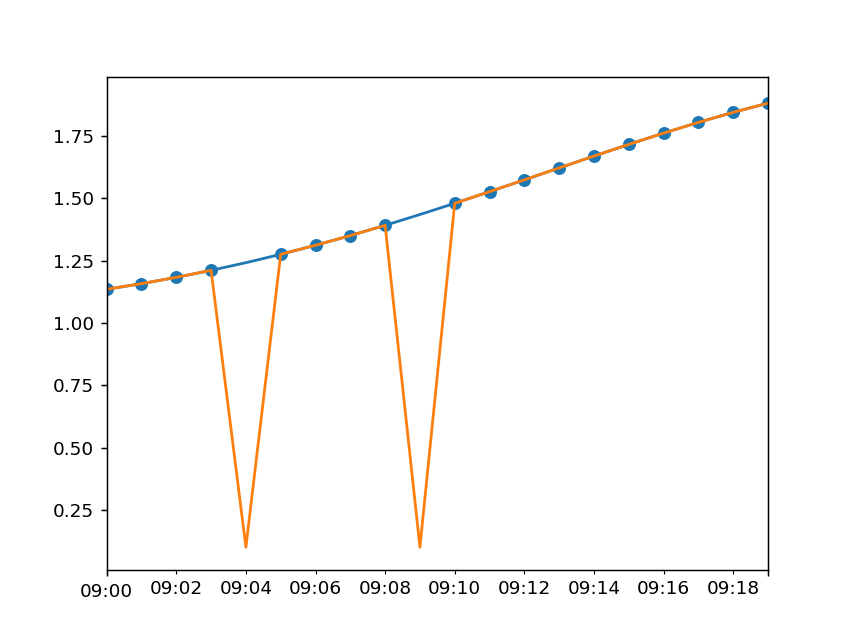

In [41]:
import scipy
fig, ax = plt.subplots()
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2) / (2 * np.power(sig, 2)))

x = np.linspace(-2, -.5, 20)
y = np.asarray([gaussian(i, 0, 1) for i in x]) + 1
y_impure = y.copy()
y_impure[4] = .1
y_impure[9] = .1
# y_impure[] = .1
# y_impure[] = .1
# y_impure[22] = .1

dr = pd.date_range(start='2017-01-01 09:00:00', end='2017-01-01 09:19:00', freq='1min')

clean = pd.Series(y, index=dr)
dirty = pd.Series(y_impure, index=dr)

clean.plot(ax=ax)
dirty.plot(ax=ax)

ans = pvlib.clearsky.detect_clearsky(dirty, clean, dirty.index, 4)

ax.scatter(dirty.index[ans], dirty[ans])

This example highlights a potential issue with the algorihtm in PVLib.  The 4 points in the middle of the two valleys (9:04-9:08) are labelled clear because they appear in a single window that is labelled as clear.  This is very generous for these points as they would likely fail in surrounding windows.  Additionally, the points on the outside of the valleys would also fail as the valley floor was inlcuded in windows where they existed.  In practice, I'm not so sure this is a great idea.  Labelling points as clear that are included in failing windows might overestimate clarity.

In [42]:
clear_skies2 = clear_skies[(clear_skies.index >= '2014-07-30') & (clear_skies.index < '2014-07-31')]

In [43]:
example = sample[(sample.index >= '2014-07-30') & (sample.index < '2014-07-31')]

<IPython.core.display.Javascript object>


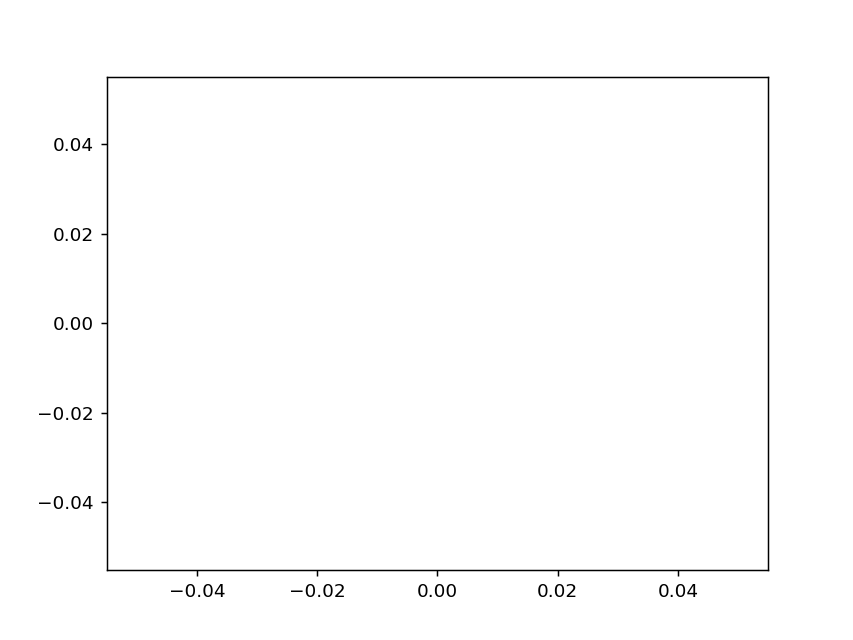

In [44]:
fig, ax = plt.subplots()
ax.plot(clear_skies2.index, 
        clear_skies2['ghi'] / np.trapz(clear_skies2['ghi'].values))
ax.plot(example.index, 
        example['Global 40-South LI-200 [W/m^2]'] / np.trapz(example['Global 40-South LI-200 [W/m^2]']))   

In [45]:
cs = np.cumsum(clear_skies2['ghi'].values / np.trapz(clear_skies2['ghi'].values))

In [46]:
cs2 = np.cumsum(example['Global 40-South LI-200 [W/m^2]'].values / np.trapz(example['Global 40-South LI-200 [W/m^2]']))

<IPython.core.display.Javascript object>


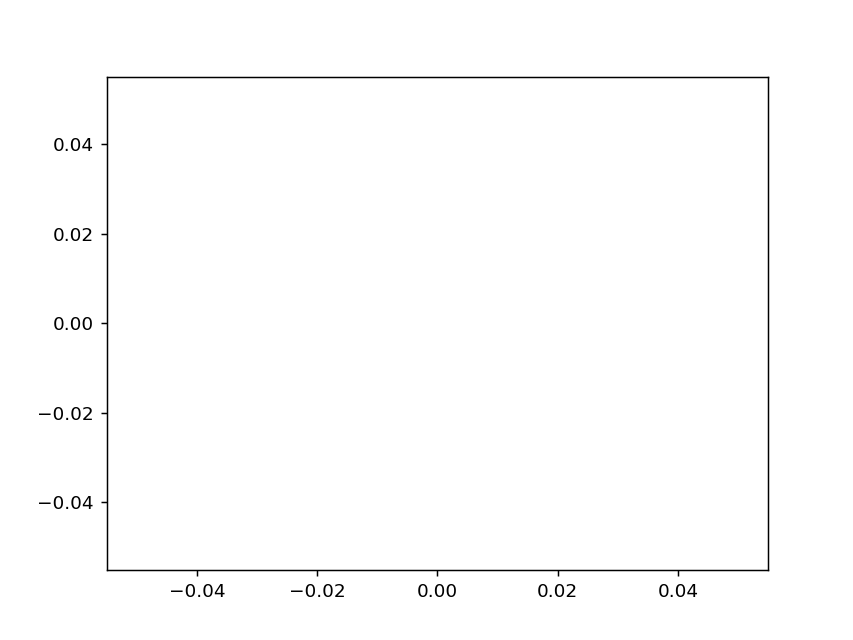

In [47]:
fig, ax = plt.subplots()
ax.plot(clear_skies2.index, cs)
ax.plot(example.index, cs2)